# 3.0 - baseline

In this notebook I basically copy NGCF and LightGCN models from [here](https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377) and evaluate them on dataset to get a baseline.


In [1]:
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("../")

from benchmark.train import (  # noqa: E402
    baseline_train_and_eval as train_and_eval,
    TrainParameters,
    device,
)
from benchmark.models import RecSysGNN  # noqa: E402

In [2]:
# load dataframes
train = pd.read_csv("../data/interim/train.csv")
test = pd.read_csv("../data/interim/test.csv")

In [3]:
PARAMETERS = TrainParameters(
    EPOCHS=40,
    BATCH_SIZE=1024,
    LR=5e-3,
    DECAY=1e-4,
    K=10,
)

In [4]:
latent_dim = 64
n_layers = 3

n_users = train.user_id_idx.nunique()
n_items = train.item_id_idx.nunique()

lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model="LightGCN",
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=PARAMETERS.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2598, 64])]


In [5]:
light_losses, light_metrics = train_and_eval(
    lightgcn, optimizer, train, test, PARAMETERS
)

  0%|          | 0/40 [00:00<?, ?it/s]

100%|██████████| 40/40 [04:29<00:00,  6.73s/it]


In [6]:
# save losses and metrics for later comparison
np.savetxt("../data/benckmark/light_losses.txt", light_losses)
np.savetxt("../data/benckmark/light_metrics.txt", light_metrics)

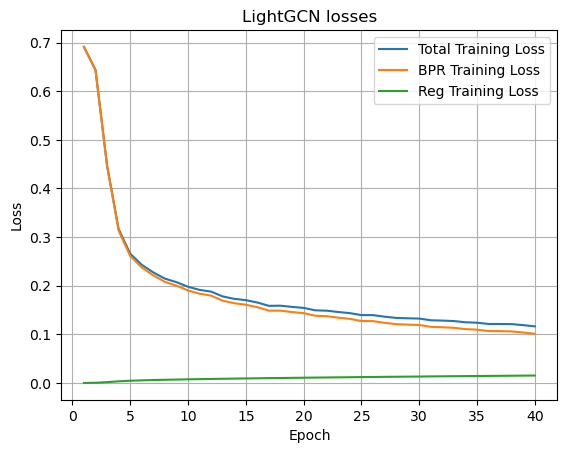

In [7]:
epoch_list = [(i + 1) for i in range(PARAMETERS.EPOCHS)]
plt.plot(epoch_list, light_losses[:, 0], label="Total Training Loss")
plt.plot(epoch_list, light_losses[:, 1], label="BPR Training Loss")
plt.plot(epoch_list, light_losses[:, 2], label="Reg Training Loss")

plt.title("LightGCN losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.legend()

# save figure
plt.savefig("../reports/figures/lightgcn_losses.png")

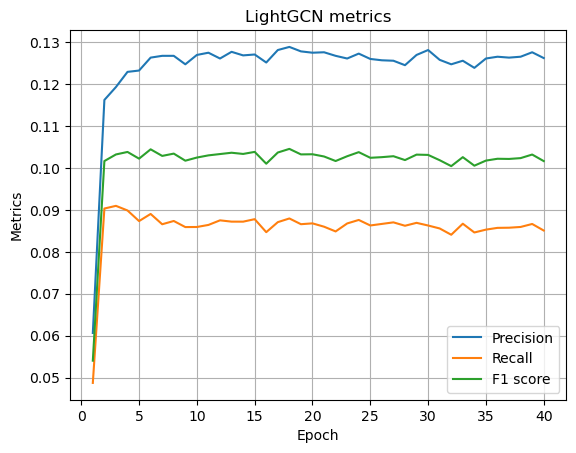

In [8]:
plt.plot(epoch_list, light_metrics[:, 0], label="Precision")
plt.plot(epoch_list, light_metrics[:, 1], label="Recall")
plt.plot(epoch_list, light_metrics[:, 2], label="F1 score")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.grid()
plt.legend()

plt.title("LightGCN metrics")

# save figure
plt.savefig("../reports/figures/lightgcn_metrics.png")

In [9]:
torch.save(lightgcn.state_dict(), "../models/lightgcn.pt")

In [10]:
ngcf = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model="NGCF",
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=PARAMETERS.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2598, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [11]:
ngcf_losses, ngcf_metrics = train_and_eval(ngcf, optimizer, train, test, PARAMETERS)

100%|██████████| 40/40 [08:07<00:00, 12.20s/it]


In [12]:
# save model
torch.save(ngcf.state_dict(), "../models/ngcf.pt")

In [13]:
# save losses and metrics for later comparison
np.savetxt("../data/benckmark/ngcf_losses.txt", ngcf_losses)
np.savetxt("../data/benckmark/ngcf_metrics.txt", ngcf_metrics)

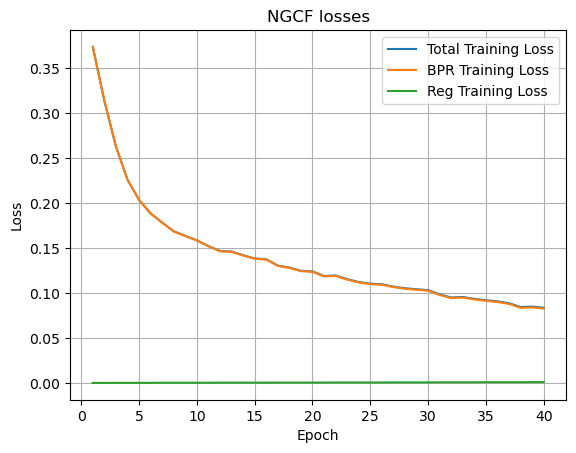

In [14]:
epoch_list = [(i + 1) for i in range(PARAMETERS.EPOCHS)]
plt.plot(epoch_list, ngcf_losses[:, 0], label="Total Training Loss")
plt.plot(epoch_list, ngcf_losses[:, 1], label="BPR Training Loss")
plt.plot(epoch_list, ngcf_losses[:, 2], label="Reg Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.title("NGCF losses")

# save figure
plt.savefig("../reports/figures/ngcf_losses.png")

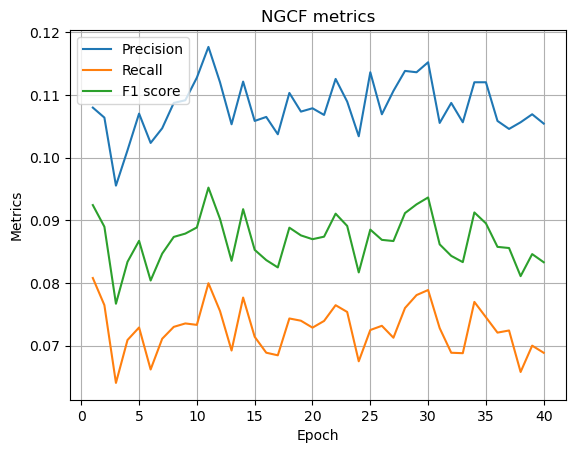

In [15]:
plt.plot(epoch_list, ngcf_metrics[:, 0], label="Precision")
plt.plot(epoch_list, ngcf_metrics[:, 1], label="Recall")
plt.plot(epoch_list, ngcf_metrics[:, 2], label="F1 score")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()
plt.grid()

plt.title("NGCF metrics")

# save figure
plt.savefig("../reports/figures/ngcf_metrics.png")